# Entire - IA - Model - Developpement - Worflow



*   Calssifier les émmotion des gens sur la base de leurs expressions 
*   20 000 images d'expression labélisées


*   Nous allons à la fois prédire une émotion : Colère, paine, joie, ...
*   Et aussi prédire le position des points clef du visage/marqueur du visage (voir image)
  * => 2 Modèles distincts



![key Facial Points](https://raw.githubusercontent.com/macbrennan90/macbrennan90.github.io/master/images/horizontal-flipping.png)



*   La combinaison de ces 2 expressions, permet une approche plus holistique (plus dans un tout / non-atomique)



In [ ]:
from google.colab import drive
drive.mount('/gdrive')

In [2]:
%cd /gdrive/MyDrive/NeuralNets/ANN\ Practices/Emotion\ Detection

/gdrive/MyDrive/NeuralNets/ANN Practices/Emotion Detection


In [ ]:
%ls

 data/  'photo 1.jpeg'  'photo 2.jpg'   Untitled0.ipynb


~# Librairies

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import PIL
from PIL import *
import pickle 

import cv2
from google.colab.patches import cv2_imshow

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, optimizers
from tensorflow.keras import *
from tensorflow.keras import backend as K
from keras.models import Model

from IPython.display import display



~# Charger les images

In [4]:
keyfacial_df = pd.read_csv('data/data.csv')

In [ ]:
keyfacial_df.head(1)

left_eye_center_x  ...                                              Image
0          66.033564  ...  238 236 237 238 240 240 239 241 241 243 240 23...

[1 rows x 31 columns]

In [ ]:
keyfacial_df.head(1)["Image"]

0    238 236 237 238 240 240 239 241 241 243 240 23...
Name: Image, dtype: object

- Quel est la taille de mes images ?

In [ ]:
keyfacial_df["Image"].shape

(2140,)

In [ ]:
keyfacial_df.head(1)["Image"].shape

(1,)

In [ ]:
keyfacial_df.head(1)["Image"].values[0]

'238 236 237 238 240 240 239 241 241 243 240 239 231 212 190 173 148 122 104 92 79 73 74 73 73 74 81 74 60 64 75 86 93 102 100 105 109 114 121 127 132 134 137 137 140 139 138 137 137 140 141 143 144 147 148 149 147 147 148 145 147 144 146 147 147 143 134 130 130 128 116 104 98 90 82 78 85 88 86 80 77 87 108 111 115 128 133 188 242 252 250 248 251 250 250 250 235 238 236 238 238 237 238 242 241 239 237 233 215 195 187 156 119 103 93 78 68 73 75 75 72 75 70 61 66 77 91 96 106 108 113 120 125 131 134 138 135 138 139 145 144 144 142 140 141 141 148 147 150 149 152 151 149 150 147 148 144 148 144 146 146 143 139 128 132 135 128 112 104 97 87 78 79 83 85 83 75 75 89 109 111 117 117 130 194 243 251 249 250 249 250 251 237 236 237 238 237 238 241 238 238 238 241 221 195 187 163 124 106 95 81 68 70 73 73 72 73 69 65 74 82 94 103 110 111 119 127 135 140 139 144 144 145 143 143 143 146 144 144 147 146 148 147 150 146 147 150 150 149 147 147 144 147 144 149 146 144 144 144 140 131 133 133 125 110 

In [ ]:
type(keyfacial_df.head(1)["Image"].values[0]) # Il l'on peut-être transformer en chaine pour économiser a taille ?

str

In [ ]:
len(keyfacial_df.head(1)["Image"].values[0])

33593

- En faite on voit que la matrice à été aplatit pour être un tableau à 1 dimension --> redimensioné, AVANT je dois transformer cette chaine en un Numpy array (fromstring)

In [ ]:
keyfacial_df['Image'] = keyfacial_df['Image'].apply( lambda x : np.fromstring(x, dtype = int, sep = ' ').reshape(96, 96) ) # chaque x = une ligne

- Voyons voir maintenant

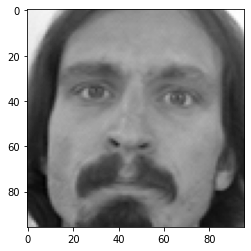

In [ ]:
plt.imshow(keyfacial_df.head(1)["Image"].values[0], cmap='gray')

- Quelques infos sur le dataframe

In [ ]:
keyfacial_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2140 entries, 0 to 2139
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          2140 non-null   float64
 1   left_eye_center_y          2140 non-null   float64
 2   right_eye_center_x         2140 non-null   float64
 3   right_eye_center_y         2140 non-null   float64
 4   left_eye_inner_corner_x    2140 non-null   float64
 5   left_eye_inner_corner_y    2140 non-null   float64
 6   left_eye_outer_corner_x    2140 non-null   float64
 7   left_eye_outer_corner_y    2140 non-null   float64
 8   right_eye_inner_corner_x   2140 non-null   float64
 9   right_eye_inner_corner_y   2140 non-null   float64
 10  right_eye_outer_corner_x   2140 non-null   float64
 11  right_eye_outer_corner_y   2140 non-null   float64
 12  left_eyebrow_inner_end_x   2140 non-null   float64
 13  left_eyebrow_inner_end_y   2140 non-null   float

- Et plus 

In [ ]:
keyfacial_df.describe()

left_eye_center_x  ...  mouth_center_bottom_lip_y
count        2140.000000  ...                2140.000000
mean           66.221549  ...                  82.630412
std             2.087683  ...                   4.813557
min            47.835757  ...                  57.232296
25%            65.046300  ...                  79.417480
50%            66.129065  ...                  82.388899
75%            67.332093  ...                  85.697976
max            78.013082  ...                  95.808983

[8 rows x 30 columns]

--> On voit que l'on est à peu pr_s à la même hauteur des 2 yeux : 36, 37 pixels en moyenne

- Y at-il des null ?

In [ ]:
keyfacial_df.isnull().sum()

left_eye_center_x            0
left_eye_center_y            0
right_eye_center_x           0
right_eye_center_y           0
left_eye_inner_corner_x      0
left_eye_inner_corner_y      0
left_eye_outer_corner_x      0
left_eye_outer_corner_y      0
right_eye_inner_corner_x     0
right_eye_inner_corner_y     0
right_eye_outer_corner_x     0
right_eye_outer_corner_y     0
left_eyebrow_inner_end_x     0
left_eyebrow_inner_end_y     0
left_eyebrow_outer_end_x     0
left_eyebrow_outer_end_y     0
right_eyebrow_inner_end_x    0
right_eyebrow_inner_end_y    0
right_eyebrow_outer_end_x    0
right_eyebrow_outer_end_y    0
nose_tip_x                   0
nose_tip_y                   0
mouth_left_corner_x          0
mouth_left_corner_y          0
mouth_right_corner_x         0
mouth_right_corner_y         0
mouth_center_top_lip_x       0
mouth_center_top_lip_y       0
mouth_center_bottom_lip_x    0
mouth_center_bottom_lip_y    0
Image                        0
dtype: int64

 * # Plot images avec leur marqueurs de visage

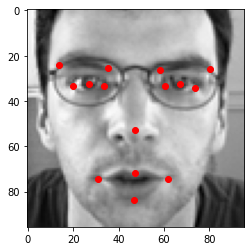

In [ ]:
index = np.random.randint(1, len(keyfacial_df))
plt.imshow(keyfacial_df["Image"][index], cmap='gray')

for col in range(1, 31, 2):
  plt.plot(keyfacial_df.loc[index][col - 1], keyfacial_df.loc[index][col], 'ro') # forme + couleur marqueur : red + o forme

- Grille d'images

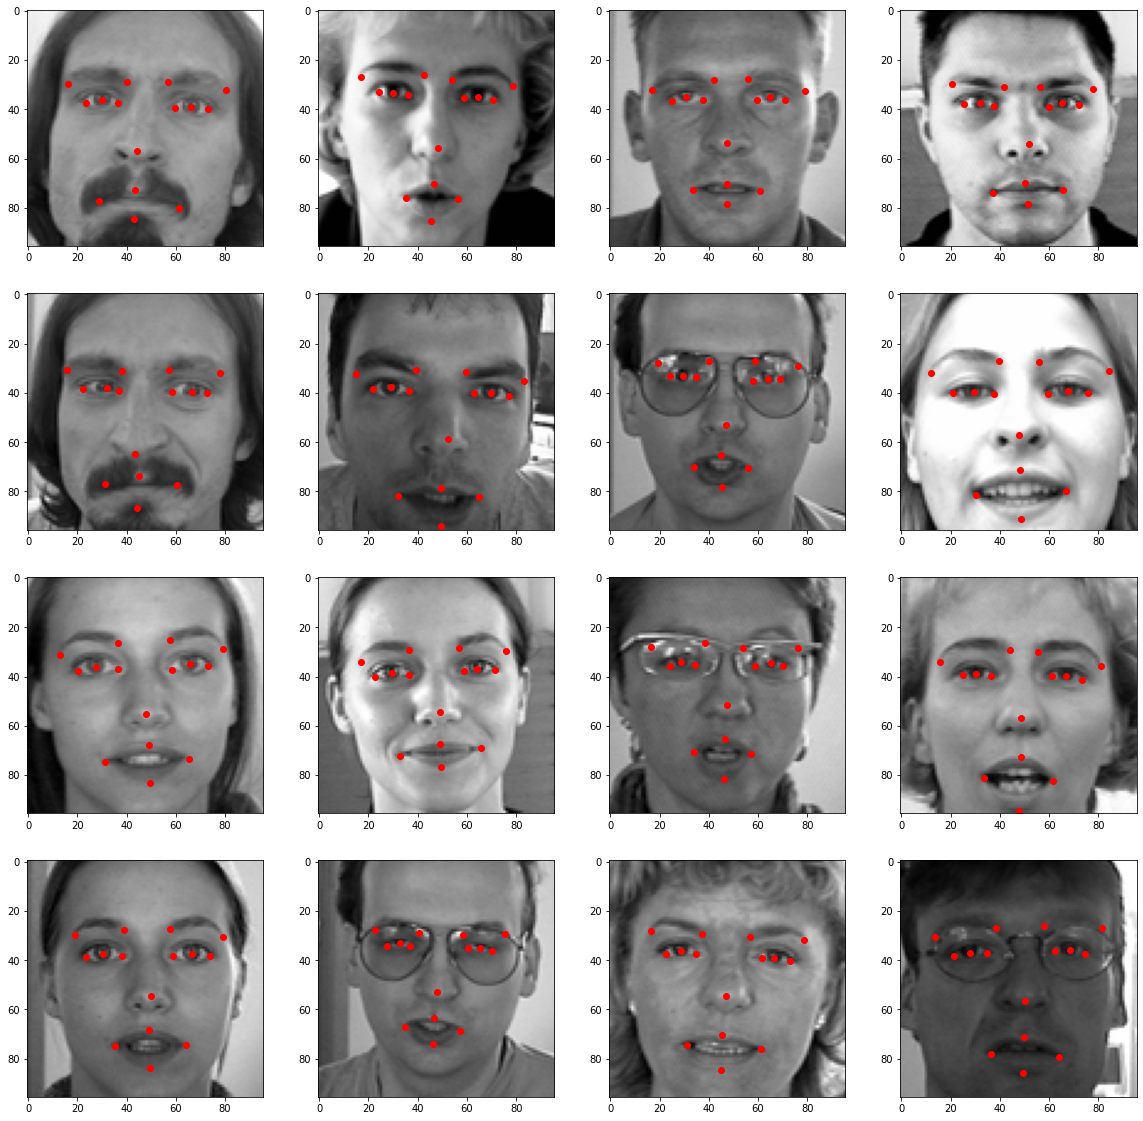

In [ ]:
fig = plt.figure(figsize = (20, 20))

for i in range(16):

  # Ajouter un subplot
  ax = fig.add_subplot(4, 4, i + 1) # sous graphe de 4 x 4 + position in the grid -- A subplot is a way to split the available region into a grid of plots so that we will be able to plot multiple graphs in a single window
  plt.imshow(keyfacial_df['Image'][i], cmap = 'gray')

  # Ajouter les données du subplot
  for j in range(1, 31, 2):
    plt.plot(keyfacial_df.loc[i][j-1], keyfacial_df.loc[i][j], 'ro')

- Sanity Check : Les données font-elles sens ?


Note sur sur add_subplot
```
The first argument is the number of plots in each row and the second the number of plots per column (see also the matplotlib.pyplot.subplot documentation). So the total number of plots avaiable in your case is: 4*4 = 16. If you want to create 64 you could for example use: (8, 8, i + 1)
```



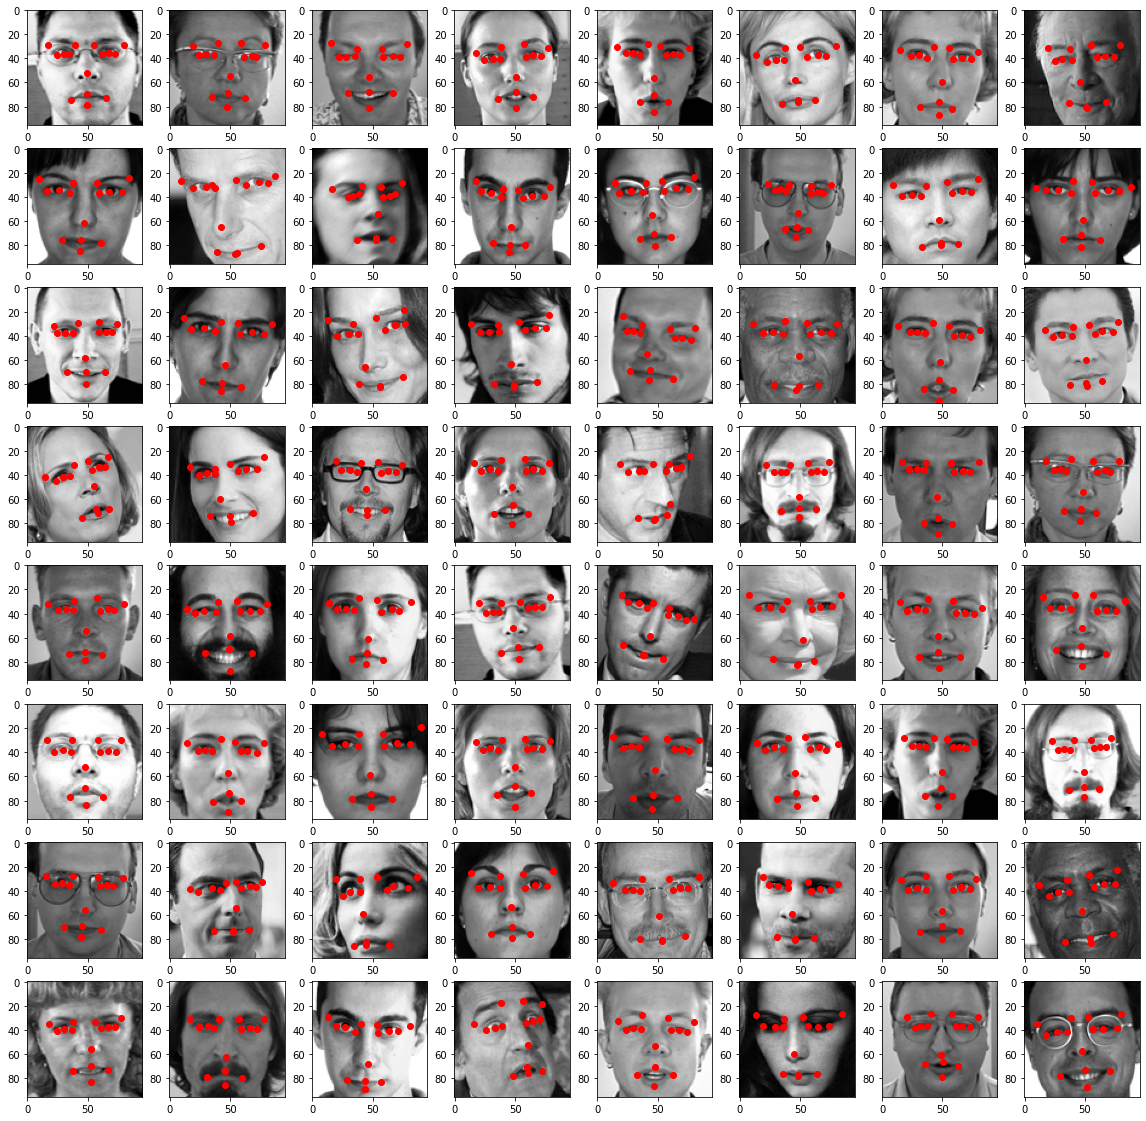

In [ ]:
fig = plt.figure(figsize = (20, 20))

for i in range(64):

  # Ajouter un subplot
  ax = fig.add_subplot(8, 8, i + 1) # sous graphe de 4 x 4 + position in the grid -- A subplot is a way to split the available region into a grid of plots so that we will be able to plot multiple graphs in a single window
  rd = np.random.randint(0, len(keyfacial_df))
  image = plt.imshow(keyfacial_df['Image'][rd], cmap = 'gray')

  # Ajouter les données du subplot
  for j in range(1, 31, 2):
    plt.plot(keyfacial_df.loc[rd][j-1], keyfacial_df.loc[rd][j], 'ro')

 * # [Image Augmentation] Augentation de données pour une meilleurs généralisation 

In [ ]:
# Copier dataFrame
keyfacial_df_copy = keyfacial_df.copy()

# Colonnes suaf la dernière
columns = keyfacial_df.columns[:-1]
columns

Index(['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'left_eye_outer_corner_x',
       'left_eye_outer_corner_y', 'right_eye_inner_corner_x',
       'right_eye_inner_corner_y', 'right_eye_outer_corner_x',
       'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x',
       'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x',
       'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x',
       'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x',
       'mouth_right_corner_y', 'mouth_center_top_lip_x',
       'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x',
       'mouth_center_bottom_lip_y'],
      dtype='object')

 Transformation 1 : Retourner horizontalement les images

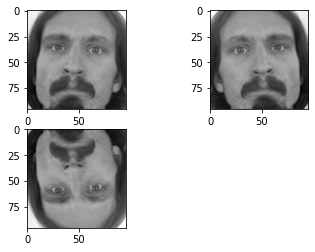

In [ ]:
fig = plt.figure()
# Adds a subplot at the 1st position - Normal
fig.add_subplot(2, 2, 1)
plt.imshow(keyfacial_df.Image[0], cmap='gray')

# Adds a subplot at the 2th position - Horz flip
fig.add_subplot(2, 2, 2)
plt.imshow(np.flip(keyfacial_df.Image[0], axis = 1), cmap='gray')

# Adds a subplot at the 3th position - Vert flip
fig.add_subplot(2, 2, 3)
plt.imshow(np.flip(keyfacial_df.Image[0], axis = 0), cmap='gray')

fig.show()

- Un tel changement implique de modifier en conséquence les coord y (vertical) ou x (horizontal) pour retrouver une cohérence des données

In [ ]:
# 1 . le retournement Horizontal
keyfacial_df_copy['Image'] = keyfacial_df_copy['Image'].apply( lambda x : np.flip(x, axis = 1))

# 2 . Retrouver la cohérece des données en modifiant les coord x
for col in range(len(columns)):
  if col % 2 == 0: # les coord x sont données par les indices de colonne : 0, 2, 4, ... (paires)
    keyfacial_df_copy[columns[col]] = keyfacial_df_copy[columns[col]].apply( lambda x : 96 - float(x)) # Accès par nom de colonne

- Comparaison

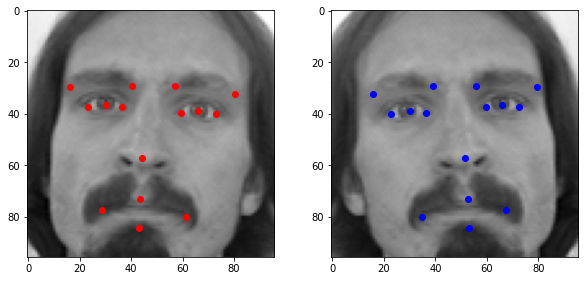

In [ ]:
fig = plt.figure(figsize=(10, 10))
# Adds a subplot at the 1st position - Normal
fig.add_subplot(2, 2, 1)
plt.imshow(keyfacial_df.Image[0], cmap='gray')

# Ajouter les données du subplot 1
for j in range(1, 31, 2):
  plt.plot(keyfacial_df.loc[0][j-1], keyfacial_df.loc[0][j], 'ro')

# Adds a subplot at the 2th position - Horz flip
fig.add_subplot(2, 2, 2)
plt.imshow(np.flip(keyfacial_df.Image[0], axis = 1), cmap='gray')

# Ajouter les données du subplot 2
for j in range(1, 31, 2):
  plt.plot(keyfacial_df_copy.loc[0][j-1], keyfacial_df_copy.loc[0][j], 'bo')

fig.show()

- Concatener le dataframe originel avec données non-transformé et la copy avec images+data transforme

In [ ]:
augmented_df = np.concatenate((keyfacial_df, keyfacial_df_copy))

augmented_df.shape

(4280, 31)

 Transformation 2 : Aléatoirement augmenter la luminisité des image



In [ ]:
# Borner les valeurs 
a = np.arange(10) # [0, .... , 9 ]
np.clip(a, 1, 8) # Les valeurs <1 sont ramenner a 1, >8 ramenner à 8

np.random.uniform(1.5, 2)

1.9560744146690863

In [ ]:
import random
random.uniform(1.5, 2)

1.5210228825407532

In [ ]:
# Copier dataFrame
keyfacial_df_copy = keyfacial_df.copy()

# Comme la multiplication peut entrainer un dépssement par rapport à la plage des pixel (0 <--> 255), il faut trouve un moyen de les restreindre
keyfacial_df_copy['Image'] = keyfacial_df_copy['Image'].apply( lambda x : np.clip( np.random.uniform(1.5, 2) * x, 0.0, 255.0) )

augmented_df = np.concatenate((augmented_df, keyfacial_df_copy))

augmented_df.shape

(6420, 31)

- Show

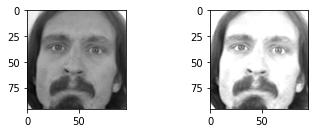

In [ ]:
fig = plt.figure()
# Adds a subplot at the 1st position - Normal
fig.add_subplot(2, 2, 1)
plt.imshow(keyfacial_df.Image[0], cmap='gray')

# Adds a subplot at the 2th position - Horz flip
fig.add_subplot(2, 2, 2)
plt.imshow(keyfacial_df_copy.Image[0], cmap='gray')

fig.show()

* # Normalization & Préparation des données

In [ ]:
# Reup images
imgs = augmented_df[:, 30]

# Rescale
imgs /= 255.

# Creer les entrées
X = np.empty( (len(imgs), 96, 96, 1) )

In [ ]:
tmp = X.copy()

In [ ]:
for i in range(len(imgs)):
  tmp[i, ] = imgs[i]

ValueError: ignored

In [ ]:
for i in range(len(imgs)):
  X[i, ] = np.expand_dims(imgs[i], axis = 2) # 96 (0), 96 (1), 1 (2)

# Convertir en array de float32
X = np.asarray(X).astype(np.float32)

- Créer les sorties (coord x et y des marqueur de visages)

In [ ]:
y = augmented_df[:, :30]
y = np.asarray(y).astype(np.float32)
y.shape

(6420, 30)

- Split train and test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)

- Sanity check

In [ ]:
X_test.shape, y_test.shape, 0.10*6420

((642, 96, 96, 1), (642, 30), 642.0)

* # Construire le modèle Residual Network

In [ ]:
from keras.layers import Dense, Flatten, Conv2D, BatchNormalization, Activation, MaxPool2D, Add, AveragePooling2D, Dropout, ZeroPadding2D

- fct construction ID/Conv Block

In [ ]:
def res_block(X, filters, stage):

  # Conv Block
  X_copy = X

  f1, f2, f3 = filters

  # Branche Principale
  X = Conv2D(f1, (1,1), strides = (1, 1), name = 'res' + str(stage) + '_conv_a', kernel_initializer=glorot_uniform(seed = 0))(X)
  X = MaxPool2D((2,2))(X)
  X = BatchNormalization(axis = 3, name = 'bn' + str(stage) + '_conv_a')(X)
  X = Activation('relu')(X)

  X = Conv2D(f2, (3,3), strides = (1, 1), name = 'res' + str(stage) + '_conv_b', padding = 'same', kernel_initializer=glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis = 3, name = 'bn' + str(stage) + '_conv_b')(X)
  X = Activation('relu')(X)

  X = Conv2D(f3, (1,1), strides = (1, 1), name = 'res' + str(stage) + '_conv_c', kernel_initializer=glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis = 3, name = 'bn' + str(stage) + '_conv_c')(X)

  # RACCOURCI
  X_copy = Conv2D(f3, (1,1), strides = (1, 1), name = 'res' + str(stage) + '_conv_copy', kernel_initializer=glorot_uniform(seed = 0))(X_copy)
  X_copy = MaxPool2D((2,2))(X_copy)
  X_copy = BatchNormalization(axis = 3, name = 'bn' + str(stage) + '_conv_copy')(X_copy)

  # ADD 1 - Comme c'est comme si on apprennait la fonction ID, si on prennait que les raccourcis la taille X et tjours = a celle de la 1er entrée 
  X = Add()([X, X_copy])
  X = Activation('relu')(X)

  # Id Bl 1
  X_copy = X

  # Branche Princiale
  X = Conv2D(f1, (1,1), strides = (1, 1), name = 'res' + str(stage) + '_id_1_a', kernel_initializer=glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis = 3, name = 'bn' + str(stage) + '_id_1_a')(X)
  X = Activation('relu')(X)

  X = Conv2D(f2, (3,3), strides = (1, 1), name = 'res' + str(stage) + '_id_1_b', padding = 'same', kernel_initializer=glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis = 3, name = 'bn' + str(stage) + '_id_1_b')(X)
  X = Activation('relu')(X)

  X = Conv2D(f3, (1,1), strides = (1, 1), name = 'res' + str(stage) + '_conv__id_1_c', kernel_initializer=glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis = 3, name = 'bn' + str(stage) + '_id_1_c')(X)

  # ADD 2
  X = Add()([X, X_copy])
  X = Activation('relu')(X)

  # Id Bl 2
  X_copy = X

  # Branche Princiale
  X = Conv2D(f1, (1,1), strides = (1, 1), name = 'res' + str(stage) + '_id_2_a', kernel_initializer=glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis = 3, name = 'bn' + str(stage) + '_id_2_a')(X)
  X = Activation('relu')(X)

  X = Conv2D(f2, (3,3), strides = (1, 1), name = 'res' + str(stage) + '_id_2_b', padding = 'same', kernel_initializer=glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis = 3, name = 'bn' + str(stage) + '_id_2_b')(X)
  X = Activation('relu')(X)

  X = Conv2D(f3, (1,1), strides = (1, 1), name = 'res' + str(stage) + '_id_2_c', kernel_initializer=glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis = 3, name = 'bn' + str(stage) + '_id_2_c')(X)

  # ADD 3
  X = Add()([X, X_copy])
  X = Activation('relu')(X)

  return X

- Entrer Réseau

In [ ]:
input = Input(shape = (96,96,1), name = 'input')

# stage 1
x = ZeroPadding2D(padding = 3)(input) # 3 en largeur (a gauche +droite), 3 en longueur (haut + bas)
x = Conv2D(filters=64, kernel_size=(7,7), strides=(1,1), name = 'conv1')(x)
x = BatchNormalization(axis = 3, name = 'bn_conv1')(x)
x = Activation('relu')(x)
x = ZeroPadding2D(padding = 1)(x) # 1 en largeur, 1 en longueur
x = MaxPool2D(pool_size=(3, 3), strides=1, padding="valid")(x)

# stage 2
x = res_block(x, [64,64,256], 2)

# stage 3
x = res_block(x, [128,128,512], 3)

# stage 4
x = res_block(x, [512, 256, 128], 4)

# stage 5
x = res_block(x, [128, 128, 64], 5)

# stage 6
x = res_block(x, [64, 34, 32], 6)

# Average Pooling
x = AveragePooling2D((2,2), name = "Average_pooling")(x)

# Final Couche
x = Flatten()(x)
x = Dense(4096, activation = 'relu')(x)
x = Dropout(0.2)(x) # Régularisation (pour Généralisation)

x = Dense(2048, activation = 'relu')(x)
x = Dropout(0.2)(x) # Régularisation (pour Généralisation)

x = Dense(30, activation = 'relu')(x)

resnet = Model(input, x)

resnet.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 96, 96, 1)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_17 (ZeroPadding2 (None, 102, 102, 1)  0           input[0][0]                      
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 96, 96, 64)   3200        zero_padding2d_17[0][0]          
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 96, 96, 64)   256         conv1[0][0]                      
____________________________________________________________________________________________

* # Compiler et entrainer le modèle

In [ ]:
adam = keras.optimizers.Adam()
resnet.compile(loss = "mse", optimizer = adam, metrics = ['accuracy'])

- Checkpoint to kep the best Modèle with best validation loss

In [ ]:
checkpoint = ModelCheckpoint(filepath = 'data/facialkeypoint_weights.hdf5', verbose = 1, save_best_only = True, mode = 'min')

- Entrainement

 - **Training should be stopped when val_acc stops increasing, otherwise, your model will probably overfit. You can use an early stopping callback to stop training.**

In [ ]:
h = resnet.fit(X_train, y_train, batch_size = 32, epochs = 10, validation_split = 0.1, callbacks = [checkpoint])

Epoch 1/10
163/163 [==============================] - 39s 214ms/step - loss: 455.7548 - accuracy: 0.4423 - val_loss: 403.6545 - val_accuracy: 0.6834

Epoch 00001: val_loss improved from inf to 403.65454, saving model to data/facialkeypoint_weights.hdf5
Epoch 2/10
163/163 [==============================] - 34s 208ms/step - loss: 112.2733 - accuracy: 0.6544 - val_loss: 204.3854 - val_accuracy: 0.6834

Epoch 00002: val_loss improved from 403.65454 to 204.38536, saving model to data/facialkeypoint_weights.hdf5
Epoch 3/10
163/163 [==============================] - 34s 209ms/step - loss: 92.1623 - accuracy: 0.6535 - val_loss: 151.0786 - val_accuracy: 0.6834

Epoch 00003: val_loss improved from 204.38536 to 151.07861, saving model to data/facialkeypoint_weights.hdf5
Epoch 4/10
163/163 [==============================] - 34s 209ms/step - loss: 76.0450 - accuracy: 0.6506 - val_loss: 98.6664 - val_accuracy: 0.6834

Epoch 00004: val_loss improved from 151.07861 to 98.66641, saving model to data/fa

- Test 2

In [ ]:
checkpoint = ModelCheckpoint(filepath = 'data/facialkeypoint_weights.hdf5', verbose = 1, save_best_only = True, mode = 'min')
earlystopping = EarlyStopping(monitor='val_loss', min_delta = 100.0, patience = 1)
h = resnet.fit(X_train, y_train, batch_size = 16, epochs = 50, validation_split = 0.1, callbacks = [checkpoint, earlystopping])

Epoch 1/50
325/325 [==============================] - 41s 114ms/step - loss: 318.9101 - accuracy: 0.5017 - val_loss: 179.9240 - val_accuracy: 0.6903

Epoch 00001: val_loss improved from inf to 179.92395, saving model to data/facialkeypoint_weights.hdf5
Epoch 2/50
325/325 [==============================] - 36s 110ms/step - loss: 130.3458 - accuracy: 0.6633 - val_loss: 128.7459 - val_accuracy: 0.6003

Epoch 00002: val_loss improved from 179.92395 to 128.74594, saving model to data/facialkeypoint_weights.hdf5


-Test 3

In [ ]:
checkpoint = ModelCheckpoint(filepath = 'data/facialkeypoint2_weights.hdf5', verbose = 1, save_best_only = True, mode = 'min')
earlystopping = EarlyStopping(monitor='val_loss', min_delta = 50.0, patience = 2)
h = resnet.fit(X_train, y_train, batch_size = 16, epochs = 50, validation_split = 0.1, callbacks = [checkpoint, earlystopping])

Epoch 1/50
325/325 [==============================] - 41s 115ms/step - loss: 273.1425 - accuracy: 0.5403 - val_loss: 213.0902 - val_accuracy: 0.6903

Epoch 00001: val_loss improved from inf to 213.09024, saving model to data/facialkeypoint2_weights.hdf5
Epoch 2/50
325/325 [==============================] - 36s 110ms/step - loss: 128.2624 - accuracy: 0.6407 - val_loss: 120.2155 - val_accuracy: 0.6073

Epoch 00002: val_loss improved from 213.09024 to 120.21553, saving model to data/facialkeypoint2_weights.hdf5
Epoch 3/50
325/325 [==============================] - 36s 112ms/step - loss: 97.7103 - accuracy: 0.6457 - val_loss: 113.8192 - val_accuracy: 0.6419

Epoch 00003: val_loss improved from 120.21553 to 113.81916, saving model to data/facialkeypoint2_weights.hdf5
Epoch 4/50
325/325 [==============================] - 36s 111ms/step - loss: 83.1184 - accuracy: 0.6265 - val_loss: 178.4341 - val_accuracy: 0.6367

Epoch 00004: val_loss did not improve from 113.81916


- Test 4

In [ ]:
checkpoint = ModelCheckpoint(filepath = 'data/facialkeypoint3_weights.hdf5', verbose = 1, save_best_only = True, mode = 'min')
earlystopping = EarlyStopping(monitor='val_loss', min_delta = 10.0, patience = 3)
h = resnet.fit(X_train, y_train, batch_size = 16, epochs = 50, validation_split = 0.1, callbacks = [checkpoint, earlystopping])

Epoch 1/50
325/325 [==============================] - 41s 115ms/step - loss: 351.6853 - accuracy: 0.5097 - val_loss: 403.9333 - val_accuracy: 0.6886

Epoch 00001: val_loss improved from inf to 403.93332, saving model to data/facialkeypoint3_weights.hdf5
Epoch 2/50
325/325 [==============================] - 36s 110ms/step - loss: 210.3114 - accuracy: 0.6496 - val_loss: 115.1452 - val_accuracy: 0.2388

Epoch 00002: val_loss improved from 403.93332 to 115.14523, saving model to data/facialkeypoint3_weights.hdf5
Epoch 3/50
325/325 [==============================] - 36s 111ms/step - loss: 95.8474 - accuracy: 0.6323 - val_loss: 99.0420 - val_accuracy: 0.6298

Epoch 00003: val_loss improved from 115.14523 to 99.04202, saving model to data/facialkeypoint3_weights.hdf5
Epoch 4/50
325/325 [==============================] - 36s 111ms/step - loss: 77.9025 - accuracy: 0.6351 - val_loss: 93.2462 - val_accuracy: 0.6747

Epoch 00004: val_loss improved from 99.04202 to 93.24622, saving model to data/fa

- test 5 sans stage 5 [128, 64, 64]

In [ ]:
checkpoint = ModelCheckpoint(filepath = 'data/facialkeypoint_weights.hdf5', verbose = 1, save_best_only = True, mode = 'min')
earlystopping = EarlyStopping(monitor='val_loss', min_delta = 5.0, patience = 3)
h = resnet.fit(X_train, y_train, batch_size = 32, epochs = 50, validation_split = 0.1, callbacks = [checkpoint, earlystopping])

Epoch 1/50
325/325 [==============================] - 40s 114ms/step - loss: 277.3655 - accuracy: 0.4814 - val_loss: 156.9939 - val_accuracy: 0.6903

Epoch 00001: val_loss improved from inf to 156.99391, saving model to data/facialkeypoint_weights.hdf5
Epoch 2/50
325/325 [==============================] - 36s 111ms/step - loss: 111.2451 - accuracy: 0.5974 - val_loss: 149.1508 - val_accuracy: 0.5467

Epoch 00002: val_loss improved from 156.99391 to 149.15085, saving model to data/facialkeypoint_weights.hdf5
Epoch 3/50
325/325 [==============================] - 36s 112ms/step - loss: 85.3564 - accuracy: 0.6109 - val_loss: 476.2625 - val_accuracy: 0.4723

Epoch 00003: val_loss did not improve from 149.15085
Epoch 4/50
325/325 [==============================] - 36s 112ms/step - loss: 80.4227 - accuracy: 0.6007 - val_loss: 63.4721 - val_accuracy: 0.6903

Epoch 00004: val_loss improved from 149.15085 to 63.47206, saving model to data/facialkeypoint_weights.hdf5
Epoch 5/50
325/325 [==========

- test 6 */ ajout stage 6

In [ ]:
checkpoint = ModelCheckpoint(filepath = 'data/facialkeypoint_weights.hdf5', data/facialkeypoints-model.json' verbose = 1, save_best_only = True, mode = 'min')
earlystopping = EarlyStopping(monitor='val_loss', min_delta = 50.0, patience = 3)
h = resnet.fit(X_train, y_train, batch_size = 16, epochs = 50, validation_split = 0.1, callbacks = [checkpoint, earlystopping])

Epoch 1/50
325/325 [==============================] - 42s 115ms/step - loss: 352.0775 - accuracy: 0.5559 - val_loss: 186.8526 - val_accuracy: 0.6903

Epoch 00001: val_loss improved from inf to 186.85263, saving model to data/facialkeypoint_weights.hdf5
Epoch 2/50
325/325 [==============================] - 36s 111ms/step - loss: 118.7947 - accuracy: 0.6694 - val_loss: 99.1931 - val_accuracy: 0.6903

Epoch 00002: val_loss improved from 186.85263 to 99.19312, saving model to data/facialkeypoint_weights.hdf5
Epoch 3/50
325/325 [==============================] - 36s 112ms/step - loss: 96.5855 - accuracy: 0.6686 - val_loss: 128.6120 - val_accuracy: 0.6903

Epoch 00003: val_loss did not improve from 99.19312
Epoch 4/50
325/325 [==============================] - 36s 111ms/step - loss: 88.0936 - accuracy: 0.6527 - val_loss: 85.7496 - val_accuracy: 0.6851

Epoch 00004: val_loss improved from 99.19312 to 85.74961, saving model to data/facialkeypoint_weights.hdf5
Epoch 5/50
325/325 [==============

# ** beaucoup plus stable sur les résultat de val_accuracy**

- Save l'architecture du Modèle

In [ ]:
model_json = resnet.to_json()
with open('data/facialkeypoints-model.json', 'w') as json_file:
  json_file.write(model_json)

* # Evaluer le modèle sur le test

- res Test 1

In [ ]:
result = resnet.evaluate(X_test, y_test)
print("Acc : ", result[1], " ||  Loss : ", result[0])

21/21 [==============================] - 1s 60ms/step - loss: 83.8472 - accuracy: 0.6449
Acc :  0.644859790802002  ||  Loss :  83.84716796875


- res Test 2

In [ ]:
result = resnet.evaluate(X_test, y_test)
print("Acc : ", result[1], " ||  Loss : ", result[0])

21/21 [==============================] - 1s 59ms/step - loss: 131.6917 - accuracy: 0.6308
Acc :  0.6308411359786987  ||  Loss :  131.69168090820312


- res test 3

In [ ]:
result = resnet.evaluate(X_test, y_test)
print("Acc : ", result[1], " ||  Loss : ", result[0])

21/21 [==============================] - 1s 61ms/step - loss: 165.5674 - accuracy: 0.6433
Acc :  0.6433022022247314  ||  Loss :  165.56739807128906


- test Test 4

In [ ]:
result = resnet.evaluate(X_test, y_test)
print("Acc : ", result[1], " ||  Loss : ", result[0])

21/21 [==============================] - 1s 61ms/step - loss: 55.1370 - accuracy: 0.6651
Acc :  0.6651090383529663  ||  Loss :  55.13699722290039


- test Test 5

In [ ]:
result = resnet.evaluate(X_test, y_test)
print("Acc : ", result[1], " ||  Loss : ", result[0])

21/21 [==============================] - 1s 64ms/step - loss: 61.8646 - accuracy: 0.6854
Acc :  0.6853582262992859  ||  Loss :  61.86458969116211


- test Test 6

In [ ]:
result = resnet.evaluate(X_test, y_test)
print("Acc : ", result[1], " ||  Loss : ", result[0])

21/21 [==============================] - 1s 61ms/step - loss: 97.5957 - accuracy: 0.7103
Acc :  0.7102803587913513  ||  Loss :  97.59569549560547


- Graphical plotting

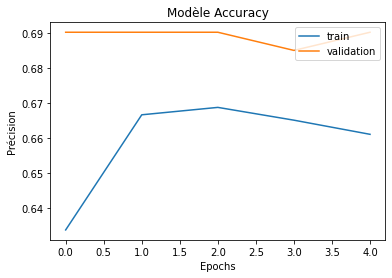

In [ ]:
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.title('Modèle Accuracy')
plt.ylabel('Précision')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'], loc = 'upper right')

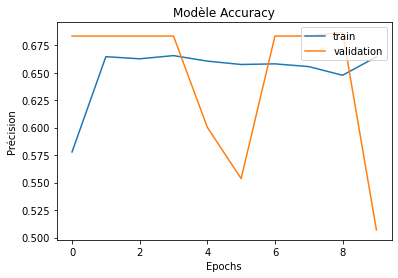

In [ ]:
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.title('Modèle Accuracy')
plt.ylabel('Précision')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'], loc = 'upper right')

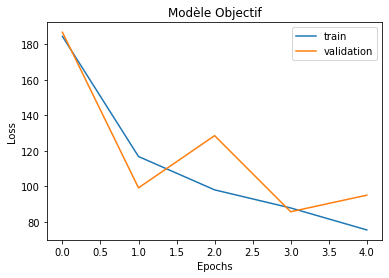

In [ ]:
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('Modèle Objectif')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'], loc = 'upper right')

- Charger un modèle

In [7]:
with open('data/facialkeypoints-model.json', 'r') as json_file:
  archit = json_file.read()

model1_keyface = tf.keras.models.model_from_json(archit)
model1_keyface.load_weights('data/facialkeypoint_weights.hdf5'),
model1_keyface.compile(optimizer = 'Adam', loss = 'mse', metrics = ['accuracy'])

# Tester le modèle
#result = model2_emotion.evaluate(X_test, y_test)
#print("Acc : ", result[1], " ||  Loss : ", result[0])

* # Partie Détection d'émotion

> On va ici entrainer un autre modèle pour clssification des émotions.
> Nos images seront de 46 x 46 pour ce modèle, ce qui veut dire qu'il faudra resize les images, lorque l'on fera tourner les 2 modèle simultanément (1er --> 96x96, 2e --> 48x48).


![Emotions](https://cdn-images-1.medium.com/max/1600/1*6xp-IY-M8lEEEN0UuUBq0w.jpeg)




- Importation des données

In [17]:
facialexpression_df = pd.read_csv('data/icml_face_data.csv')

facialexpression_df.head(10)

emotion                                             pixels
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1        0  151 150 147 155 148 133 111 140 170 174 182 15...
2        2  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
3        2  20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...
4        3  77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...
5        3  85 84 90 121 101 102 133 153 153 169 177 189 1...
6        0  30 24 21 23 25 25 49 67 84 103 120 125 130 139...
7        3  4 2 13 41 56 62 67 87 95 62 65 70 80 107 127 1...
8        4  107 107 109 109 109 109 110 101 123 140 144 14...
9        3  14 14 18 28 27 22 21 30 42 61 77 86 88 95 100 ...

- l'image est encore une fois converti en chaine ce qui veut dire, convertion !

In [19]:
facialexpression_df[' pixels'] = facialexpression_df[' pixels'].apply( lambda x : np.fromstring(x, dtype = int, sep = ' ').reshape(48, 48, 1).astype('float32') ) # chaque x = une ligne

- let see ...

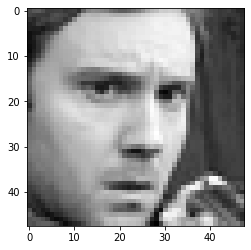

In [10]:
plt.imshow(facialexpression_df[' pixels'][0].reshape(48,48), cmap = 'gray')

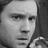

In [ ]:
cv2_imshow(facialexpression_df[' pixels'][0])

- Passer de 48,48 --> 96,96

In [20]:
def resize(x):

  """
    Resize from (48, 48) >-- to (96, 96)
  """

  img = x.reshape(48, 48)
  return cv2.resize(img, dsize = (96, 96), interpolation = cv2.INTER_CUBIC) # interpolation ~ relation entre pixels lors du retaillage

In [21]:
facialexpression_df[' pixels'] = facialexpression_df[' pixels'].apply( lambda x : resize(x))

- let see ...

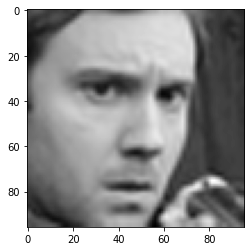

In [ ]:
plt.imshow(facialexpression_df[' pixels'][0], cmap = 'gray')

- Shape

In [ ]:
facialexpression_df.shape

(24568, 2)

- Visualisation Générale

In [ ]:
# Défintion d'un dictionnaire d'émotion
labels = {0 : 'colere', 1 : 'degout', 2 : 'triste', 3 : 'joie', 4 : 'surprise'}

Text(0.5, 1.0, '0 / colere')

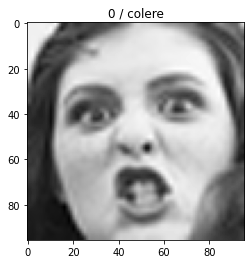

In [ ]:
x = facialexpression_df[facialexpression_df['emotion'] == 0]
x = x.reset_index()
i = np.random.randint(0, len(x))
plt.imshow(x[' pixels'][i], cmap = 'gray')
plt.title(str(x['emotion'][i]) + ' / ' + str(labels[x['emotion'][i]]) )

- Sanity check - Visualisation

In [ ]:
facialexpression_df[facialexpression_df['emotion'] == 0]

emotion                                             pixels
0            0  [[69.316925, 73.03865, 79.13719, 84.17186, 85....
1            0  [[151.09435, 150.91393, 150.65791, 148.96367, ...
6            0  [[30.493973, 28.719727, 25.83728, 22.809998, 2...
12           0  [[122.78906, 123.48457, 124.64122, 124.43849, ...
13           0  [[7.833557, 7.8534393, 7.8254547, 9.377914, 11...
...        ...                                                ...
24541        0  [[142.1779, 139.40547, 134.83519, 132.30844, 1...
24544        0  [[92.43608, 92.57077, 93.32034, 78.104645, 55....
24547        0  [[138.74457, 139.57095, 140.93991, 141.71727, ...
24564        0  [[181.71645, 179.72063, 176.40785, 175.93037, ...
24566        0  [[16.883408, 16.953583, 17.081573, 16.53476, 1...

[4953 rows x 2 columns]

In [ ]:
x = facialexpression_df[facialexpression_df['emotion'] == 0]
np.random.choice(x[' pixels'])

array([[ 84.372025,  84.09888 ,  83.61438 , ..., 202.825   , 212.92433 ,
        219.25986 ],
       [ 83.08617 ,  83.244354,  83.45682 , ..., 203.77528 , 215.23833 ,
        222.42142 ],
       [ 80.92781 ,  81.76236 ,  83.06479 , ..., 205.29912 , 218.92287 ,
        227.44907 ],
       ...,
       [206.61981 , 206.27942 , 205.92273 , ...,  82.250626,  80.85979 ,
         79.89131 ],
       [208.76996 , 207.67603 , 206.08325 , ...,  85.530075,  82.61806 ,
         80.749374],
       [210.1103  , 208.54439 , 206.17747 , ...,  87.479706,  83.6304  ,
         81.2061  ]], dtype=float32)

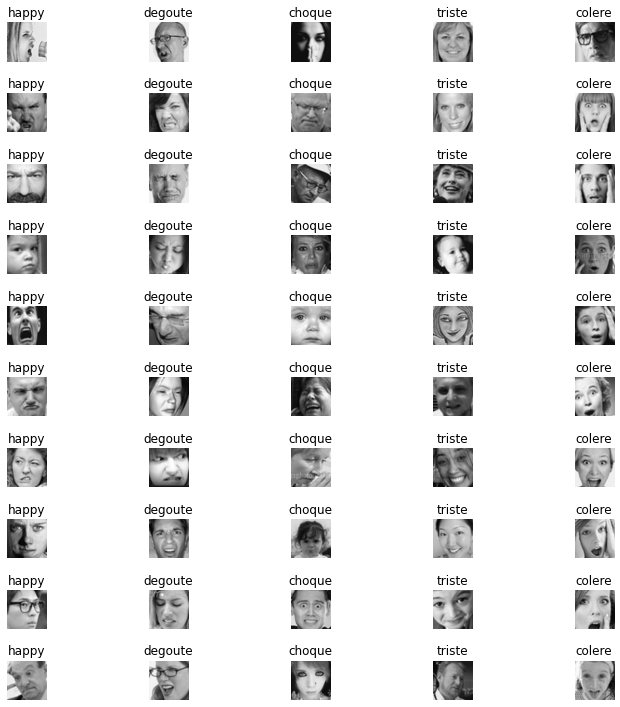

In [ ]:
nb_images = 10
nb_emotions = 5
fig, axs = plt.subplots(nrows = nb_images, ncols = nb_emotions, figsize = (10, 10))
fig.tight_layout()

for i in range(10):
    for j in range(5): # 0 --> 5
      
      x = facialexpression_df[facialexpression_df['emotion'] == j] # y_train == j donne une liste de valeur booleene (une pour chaque valeur du vecteur), x_train[y_train == j] la valeur booléene nous dit deprendre ou de ne pas prendre l'image en fonction de l'expression évalué  
      axs[i][j].imshow(np.random.choice(x[' pixels']), cmap = 'gray') # Choisir une image random x(4000, 32, 32, 3), parmis le 4000 à True d'ou le random.randint 
      axs[i][j].axis("off")
      axs[i][j].set_title(labels[j])

- Proportion de chaque émotion dans les données

In [ ]:
facialexpression_df['emotion'].value_counts()

3    8989
2    6077
0    4953
4    4002
1     547
Name: emotion, dtype: int64

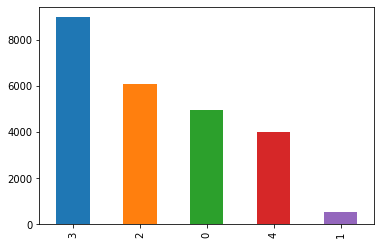

In [ ]:
# Défintion d'un dictionnaire d'émotion
facialexpression_df['emotion'].value_counts().plot(kind = 'bar', color = ['C0', 'C1', 'C2', 'C3', 'C4']) # C_i mot spécial de matplotlib
#facialexpression_df.plot.bar(y = "emotion", color = ['C0', 'C1', 'C2', 'C3', 'C4'])

- Quel est la contribution de chaque classe dans la définition du problème ?

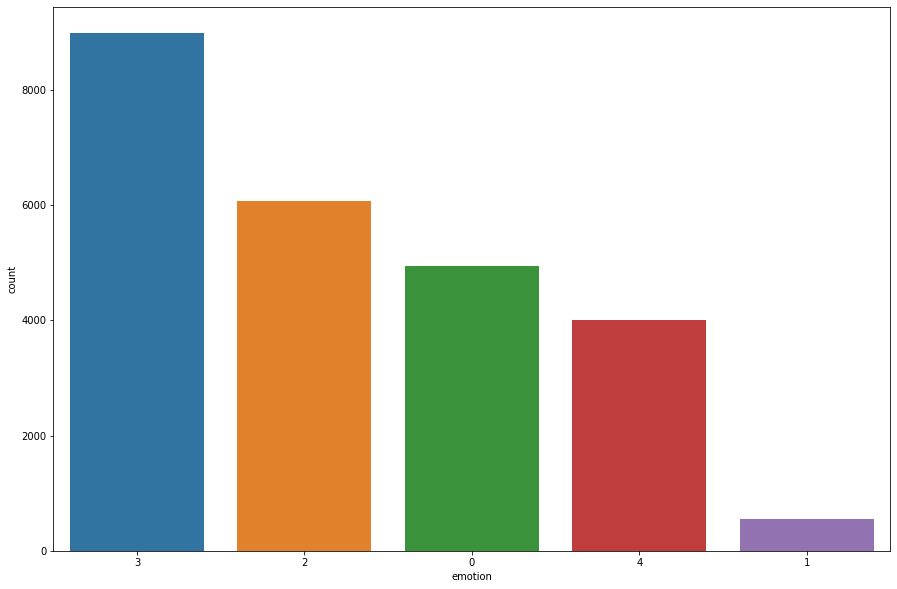

In [ ]:
plt.figure(figsize=(15,10))
sns.countplot(x = 'emotion', data = facialexpression_df, order = facialexpression_df['emotion'].value_counts().index)

--> On est donc dans le cas de données peu équilibré (degout 1 et surprise 4) .
   - Une augmentation des données serait salutaire 
   - voir un undersampling histoire de ne pas trop biaiser notre modèle.
   - D'un autre côté fait il sense de balanced les données si notre acc% vient principalement de 3 et 2 ..
   - "categorical_crossentropy loss" tend a bien fonctionner quand elle vise le meilleur % d'accuracy même pour des data unbalanced 

* # Image Augmentation

Séparer X et y ....

In [23]:
# from keras.utils import to_categorical [Révision Juin 2021]
from tensorflow.keras.utils import to_categorical

X = facialexpression_df[' pixels']
y = to_categorical(facialexpression_df['emotion'])

In [1]:
X.shape

NameError: ignored

In [25]:
X[0].shape

(96, 96)

In [26]:
X = np.stack(X, axis = 0)
X.shape

(24568, 96, 96)

In [27]:
X = X.reshape(24568, 96, 96, 1)
X.shape

(24568, 96, 96, 1)

... et en train et test

In [28]:
# Diviser 1er en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True)

# Subdiviser encore le test pour obtenir le validation
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.5, shuffle = True)

X_val.shape, y_val.shape

((2457, 96, 96, 1), (2457, 5))

- Normaliser

In [ ]:
X_train /= 255.
X_test /= 255.
X_val  /= 255.

- Définir le(s) générateur(s)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        preprocessing_function = lambda x : np.clip( np.random.uniform(1.5, 2) * x, 0.0, 255.0), # Applique une augmentation de luminosité
        fill_mode='nearest') # fill : les transformations entrainent des blanc dans l'images (niveau pixel) cause rotation => indique comment les remplir, ici grace au pixel les plus proches

- How many images does Imagedatagenerator generate (in deep learning)?

Short answer: 1) 

All the original images are just transformed (i.e. rotation, zooming, etc.) every epoch and then used for training, and 2) [Therefore] the number of images in each epoch is equal to the number of original images you have.

Long answer: 

In each epoch, the ImageDataGenerator applies a transformation on the images you have and use the transformed images for training. The set of transformations includes rotation, zooming, etc. By doing this you're somehow creating new data (i.e. also called data augmentation), but obviously the generated images are not totally different from the original ones. This way the learned model may be more robust and accurate as it is trained on different variations of the same image.

**Donc il augmente artificiellement le nombre de donnée en applicant des transformation au fil de l'eau (des batch)**

the word "augmentation" here does not mean, say, if we have 100 original training images we end up having 1000 images per epoch after augmentation (i.e. the number of training images does not increase per epoch). Instead, it means we use a different transformation of each image in each epoch; hence, if we train our model for, say, 5 epochs, we have used 5 different versions of each original image in training (or 100 * 5 = 500 different images in the whole training, instead of using just the 100 original images in the whole training). To put it differently, the total number of unique images increases in the whole training from start to finish, and not per epoch

  1.   Accepting a batch of images used for training.
  2.   Taking this batch and applying a series of random transformations to each image in the batch (including random rotation, resizing, shearing, etc.).
  3. Replacing the original batch with the new, randomly transformed batch.

  4. Training the CNN on this randomly transformed batch (i.e., the original data itself is not used for training).

https://stackoverflow.com/questions/51748514/does-imagedatagenerator-add-more-images-to-my-dataset

* # Autres techniques de ré-équilibrage

Random undersampling is a simple technique that randomly disregards observations from the training majority class until the desired balance between the classes is achieved in the training data. This takes place with no regards to the importance of each observation and data loss is likely.

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

under = RandomUnderSampler(sampling_strategy=0.5)
X_under, y_under = under.fit_r

![graphe](https://miro.medium.com/max/700/1*AZZDO1cqhuTjcCanbNfQ7A.jpeg)

* # Construction du modèle !

In [ ]:
input = Input(shape = (96,96,1), name = 'input')

# stage 1
x = ZeroPadding2D(padding = 3)(input) # 3 en largeur (a gauche +droite), 3 en longueur (haut + bas)
x = Conv2D(filters=64, kernel_size=(7,7), strides=(2,2), name = 'conv1')(x)
x = BatchNormalization(axis = 3, name = 'bn_conv1')(x)
x = Activation('relu')(x)
x = MaxPool2D(pool_size=(3, 3), strides=1, padding="valid")(x)

# stage 2
x = res_block(x, [64,64,256], 2)

# stage 3
x = res_block(x, [128,128,512], 3)

# stage 4
#x = res_block(x, [512, 256, 128], 4)

# stage 5
x = res_block(x, [128, 128, 64], 5)

# stage 6
#x = res_block(x, [64, 34, 32], 6)

# Average Pooling
x = AveragePooling2D((2,2), name = "Average_pooling")(x)

# Final Couche
x = Flatten()(x)
"""
x = Dense(4096, activation = 'relu')(x)
x = Dropout(0.2)(x) # Régularisation (pour Généralisation)

x = Dense(2048, activation = 'relu')(x)
x = Dropout(0.2)(x) # Régularisation (pour Généralisation)
"""
x = Dense(5, activation = 'softmax', name = 'dense_pred')(x)

resnet2 = Model(input, x, name = 'ResNet18')

resnet2.summary()

Model: "ResNet18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 96, 96, 1)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 102, 102, 1)  0           input[0][0]                      
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 48, 48, 64)   3200        zero_padding2d[0][0]             
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 48, 48, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________

- Compiler le modèle

In [ ]:
adam = keras.optimizers.Adam()
resnet2.compile(loss = "categorical_crossentropy", optimizer = adam, metrics = ['accuracy'])
checkpoint = ModelCheckpoint(filepath = 'data/emotion_weights.hdf5', verbose = 1, save_best_only = True, mode = 'min')
earlystopping = EarlyStopping(monitor='val_loss', mode = 'min', verbose = 1, patience = 20)

- Entrainer

In [ ]:
h = resnet2.fit(datagen.flow(X_train, y_train, batch_size = 64), 
                          steps_per_epoch= len(X_train) // 64, 
                          epochs = 10, 
                          validation_data = (X_val, y_val),
                          validation_steps = X_val.shape[0] // 64, # step per epoch pour la partie validation | 64 = batch size
                          callbacks = [checkpoint, earlystopping])

Epoch 1/10
307/307 [==============================] - 40s 97ms/step - loss: 1.5817 - accuracy: 0.3463 - val_loss: 11.6575 - val_accuracy: 0.2116

Epoch 00001: val_loss improved from inf to 11.65751, saving model to data/emotion_weights.hdf5
Epoch 2/10
307/307 [==============================] - 29s 93ms/step - loss: 1.3316 - accuracy: 0.4165 - val_loss: 78.4834 - val_accuracy: 0.1998

Epoch 00002: val_loss did not improve from 11.65751
Epoch 3/10
307/307 [==============================] - 29s 93ms/step - loss: 1.2036 - accuracy: 0.4915 - val_loss: 483.9567 - val_accuracy: 0.1616

Epoch 00003: val_loss did not improve from 11.65751
Epoch 4/10
307/307 [==============================] - 29s 95ms/step - loss: 1.0646 - accuracy: 0.5532 - val_loss: 168.1893 - val_accuracy: 0.1770

Epoch 00004: val_loss did not improve from 11.65751
Epoch 5/10
307/307 [==============================] - 29s 94ms/step - loss: 0.9648 - accuracy: 0.6145 - val_loss: 244.7416 - val_accuracy: 0.2694

Epoch 00005: val

In [ ]:
result = resnet2.evaluate(X_test, y_test)
print("Acc : ", result[1], " ||  Loss : ", result[0])

77/77 [==============================] - 1s 15ms/step - loss: 701.9465 - accuracy: 0.3280
Acc :  0.32804232835769653  ||  Loss :  701.9464721679688


In [ ]:
result = resnet2.evaluate(X_test, y_test)
print("Acc : ", result[1], " ||  Loss : ", result[0])

77/77 [==============================] - 1s 16ms/step - loss: 228.1201 - accuracy: 0.2165
Acc :  0.21652421355247498  ||  Loss :  228.1200714111328


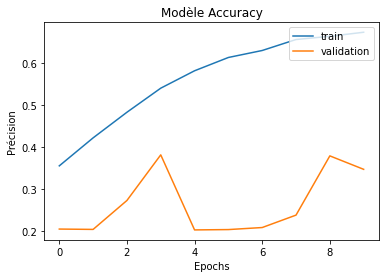

In [ ]:
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.title('Modèle Accuracy')
plt.ylabel('Précision')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'], loc = 'upper right')

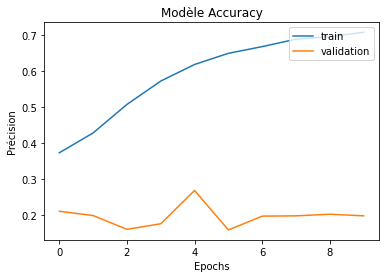

In [ ]:
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.title('Modèle Accuracy')
plt.ylabel('Précision')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'], loc = 'upper right')

- key Performance Indicator (Matrice de confusion, précision, rappel)

- La performance d'un modèle ne doit pas s'évaluer que sur la {Classification précision}, c'est une donnée insuffisante pour l'évaluation, car elle dépend bcp de l'équilbre données, voici les KPI a considérer :

  - **Classification Precision** = True P + True N / (TP + TN + FP + FN) ( correct on all population)
  - **Taux d'erreur (%)** = FP + FN / population

  - **Précision (sur le réel)** : Tp / (Nb Prédiction juste) = TP / (TP + FP)
  [ Quand le modèle prédit vrai, combien de fois a t-il eu raison ? - proportion des items pertinents parmi l'ensemble des items proposés]

  - **Rappel (sensibilité)** [ proportion des items pertinents proposés parmi l'ensemble des items pertinents - Qd la classe était VRAI, combien de fois le classifieur la deviné ? ] 
    - Rappel = TP / TP + FN 

![Precision&Rappel](https://upload.wikimedia.org/wikipedia/commons/thumb/f/ff/Precisionrappel.svg/800px-Precisionrappel.svg.png)

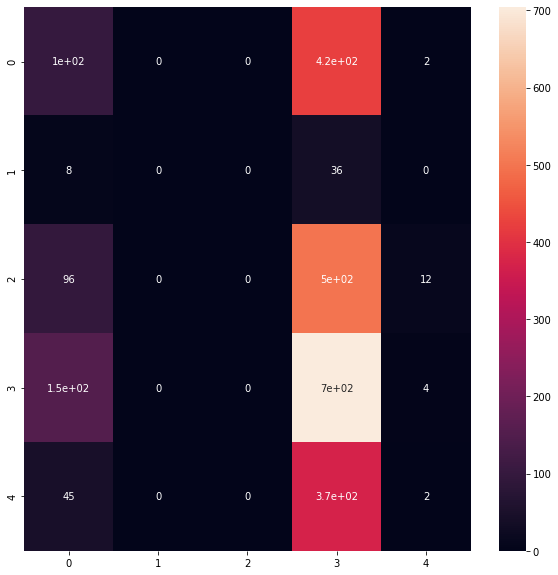

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = resnet2.predict(X_test)

cm = confusion_matrix(y_test.argmax(axis= 1), y_pred.argmax(axis=1))

plt.figure(figsize= (10, 10))
sns.heatmap(cm, annot=True)

- Calculer la précison & le recall

In [ ]:
from sklearn.metrics import classification_report


print(classification_report(y_test.argmax(axis= 1), y_pred.argmax(axis=1), zero_division=1))

              precision    recall  f1-score   support

           0       0.25      0.19      0.22       525
           1       1.00      0.00      0.00        44
           2       1.00      0.00      0.00       607
           3       0.35      0.82      0.49       861
           4       0.10      0.00      0.01       420

    accuracy                           0.33      2457
   macro avg       0.54      0.20      0.14      2457
weighted avg       0.46      0.33      0.22      2457



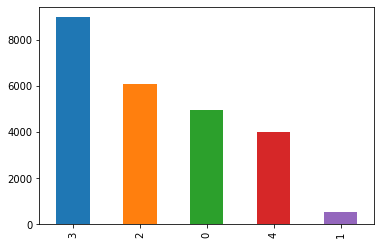

In [ ]:
# Rappel
facialexpression_df['emotion'].value_counts().plot(kind = 'bar', color = ['C0', 'C1', 'C2', 'C3', 'C4']) # C_i mot spécial de matplotlib
#facialexpression_df.plot.bar(y = "emotion", color = ['C0', 'C1', 'C2', 'C3', 'C4'])

In [ ]:
y_test.argmax(axis= 1)

array([2, 0, 2, ..., 3, 0, 3])

In [ ]:
"""
labels = {0 : 'colere', 1 : 'degout', 2 : 'triste', 3 : 'joie', 4 : 'surprise'

   precision    recall  f1-score   support

0       0.25      0.19      0.22       525
1       1.00      0.00      0.00        44
2       1.00      0.00      0.00       607
3       0.35      0.82      0.49       861
4       0.10      0.00      0.01       420


Pour 3  : precision faible mais grand recall
          Notre Classifieur pense que bcp d'image sont des personne TRISTE (grand support)
          Quand l'image est triste (il la classifie bcp comme triste)
          Mais il pense que bcp d'image qui ne sont PAS TRISTE, le sont aussi.

Pour 1 et 2 : precision haute mais recall faible
        Notre classifieur est très POINTILLEUX, peu d'image sont pour lui DEGOUT/TRISTE
        Celle qu'il reconnait/prédit comme DEGOUT/TRISTE le sont souvant
        MAIS il manque beacoup de DEGOUT ET TRISTE 
"""


 Explication sur les valeurs ! https://medium.com/@klintcho/explaining-precision-and-recall-c770eb9c69e9



- Visual Sanity Check

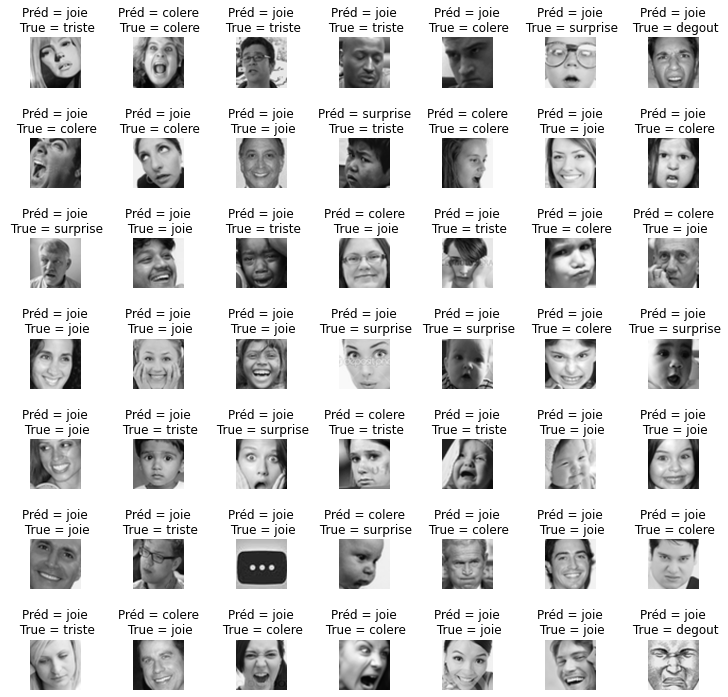

In [ ]:
# Prédiction vizuelle
fig, axs = plt.subplots(nrows = 7, ncols = 7, figsize = (12, 12))
axs = axs.ravel()

for i in range(0, 7*7):

    axs[i].imshow(X_test[i].reshape(96, 96), cmap = 'gray')

    axs[i].set_title("Préd = {}\n True = {}".format(labels[y_pred[i].argmax()], labels[y_test[i].argmax()]))

    axs[i].axis('off')

plt.subplots_adjust(wspace = 1, hspace = 1)

In [ ]:
y_pred[0].argmax(), y_test[0].argmax()

(3, 2)

- Save Modele Achitecture

In [ ]:
model_json = resnet2.to_json()
with open('data/emotion-model.json', 'w') as json_file:
  json_file.write(model_json)

* #  Charger un modèle

In [ ]:
with open('data/emotion-model.json', 'r') as json_file:
  archit =json_file.read()

model2_emotion = tf.keras.models.model_from_json(archit)
model2_emotion.load_weights('data/emotion_weights.hdf5')
model2_emotion.compile(optimizers = 'Adam', losses = 'categorical_crossentropy', metrics = ['accuracy'])

# Tester le modèle
result = model2_emotion.evaluate(X_test, y_test)
print("Acc : ", result[1], " ||  Loss : ", result[0])

ValueError: ignored

* # Combiner les 2 modèles

In [ ]:
def predict(X_test):

  # Pred Key face
  keyface_pred = resnet.predict(X_test)

  # Emotion
  emotion_predict = np.argmax(resnet2.predict(X_test), axis = 1) # [0,1,2,4,3,...]

  # Reshap (856,) to (46, 1)
  emotion_predict = np.expand_dims(emotion_predict, axis = 1)

  # Convert pred en dataFrame
  df_predict = pd.DataFrame(keyface_pred, columns = keyfacial_df.columns[:30])

  # Ajouter la pred emotion a ce DataFrame
  df_predict['emotion'] = emotion_predict

  return df_predict

In [ ]:
pred_df = predict(X_test)

In [ ]:
pred_df.head()

left_eye_center_x  left_eye_center_y  ...  mouth_center_bottom_lip_y  emotion
0          33.778198          36.813263  ...                  82.034660        3
1          37.098610          38.784027  ...                  85.913040        0
2          49.825283          37.183784  ...                  80.831993        3
3          36.981194          37.387173  ...                  82.504486        3
4          61.800209          35.295624  ...                  79.417618        3

[5 rows x 31 columns]

In [ ]:
pred_df['emotion'].value_counts()

3    544
0     91
4      7
Name: emotion, dtype: int64

--> Déjà, on voit que notre test n'est pas équilibré <--

- Sanity Check

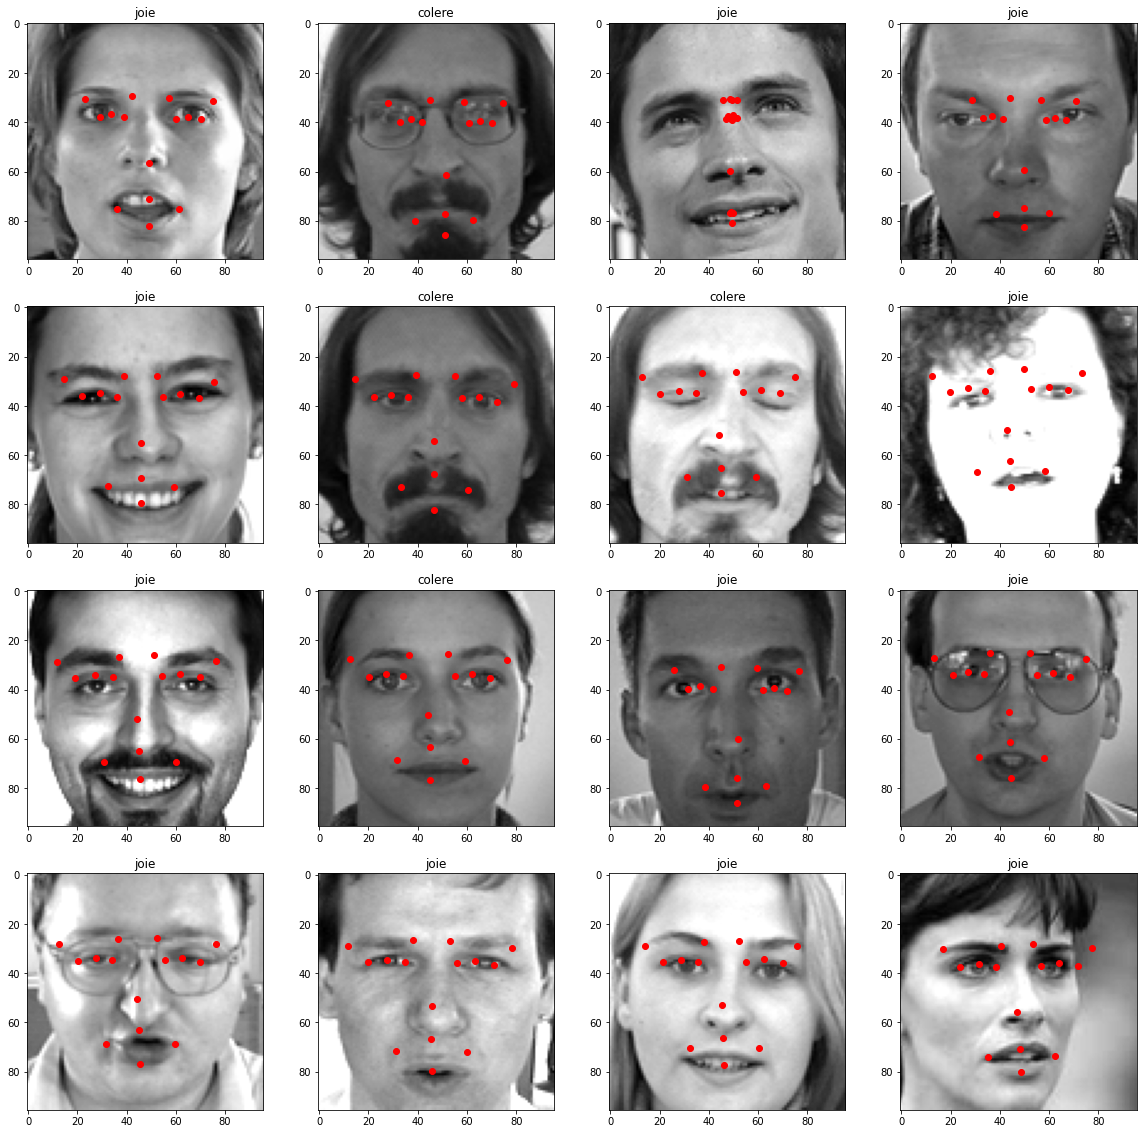

In [ ]:
fig = plt.figure(figsize = (20, 20))

for i in range(16):

  # Ajouter un subplot
  ax = fig.add_subplot(4, 4, i + 1) # sous graphe de 4 x 4 + position in the grid -- A subplot is a way to split the available region into a grid of plots so that we will be able to plot multiple graphs in a single window
  plt.imshow(X_test[i].reshape((96,96)), cmap = 'gray')

  # Ajouter les données du subplot
  for j in range(1, 31, 2):
    plt.plot(pred_df.loc[i][j-1], pred_df.loc[i][j], 'ro')

  # Ajouter emotion en légende
  plt.title(labels[pred_df['emotion'][i]])

- ** - Bon ... pour les marqueurs de visage ça passe pour les émotion, va falloir revoir le modèle**

---------

-------

* # Save Modèle for deployement

In [ ]:
import os
import json
import tensorflow.keras.backend as K

def deploy(directory, model):

  """
    Store the modèle in a format deployable par tensorflow serving
  """

  # Créer un répertoire
  MODEL_DIR = directory

  # Spécifier un n] de version
  version = 1

  # Joindre chemin + n° version
  export_path = os.path.join(MODEL_DIR, str(version))
  print('export path is = {}\n'.format(export_path))

  # Save le modèle par tensorflow tf.save_model.save, une fonction conçu pour sauvegarder un modèle approprié pour un serveur utilisant tensorflow serving
  if os.path.isdir(export_path):
    # if already exist
    print("{} already exist, suppression de l'existant".format(export_path))
    %lrm -r {export_path}

  tf.saved_model.save(resnet2, export_path)

  os.environ['MODEL_DIR'] = MODEL_DIR


- Serveuriser le modèle en utilisant Tensorflow Serving

In [ ]:
# Ajouter tensorflow-model-server package to our list of packages
!echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | apt-key add -
!apt update

deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2943  100  2943    0     0  49881      0 --:--:-- --:--:-- --:--:-- 49881
OK
Get:1 http://storage.googleapis.com/tensorflow-serving-apt stable InRelease [3,012 B]
Hit:2 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  

- Installer tensorflow model server

In [ ]:
!apt-get install tensorflow-model-server

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  tensorflow-model-server
0 upgraded, 1 newly installed, 0 to remove and 19 not upgraded.
Need to get 223 MB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://storage.googleapis.com/tensorflow-serving-apt stable/tensorflow-model-server amd64 tensorflow-model-server all 2.4.1 [223 MB]
Fetched 223 MB in 3s (78.3 MB/s)
Selecting previously unselected package tensorflow-model-server.
(Reading database ... 146442 files and directories currently installed.)
Preparing to unpack .../tensorflow-model-server_2.4.1_all.deb ...
Unpacking tensorflow-model-server (2.4.1) ...
Setting up tensorflow-model-server (2.4.1) ...


- lancer tensorflow serving
  - params :
    - rest_api_port : port for REST request
    - model_name : utiliser dans l'URL de requpete REST
    - model_base_path : repertoire de suauvegarde du modèle

In [ ]:
deploy('/model', resnet2)

export path is = /model/1

/model/1 already exist, suppression de l'existant


UsageError: Line magic function `%lrm` not found.


- Définier les paramètres server

In [ ]:
%%bash --bg 
nohup tensorflow_model_server \
  --rest_api_port=4501 \
  --model_name=emotion_model \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1

Starting job # 3 in a separate thread.


- le serveur tourne, on peut vérifier les logs

In [ ]:
%ls

 curl   data/  'photo 1.jpeg'  'photo 2.jpg'   server.log   Untitled0.ipynb


In [ ]:
!tail server.log 

2021-02-22 14:39:29.229485: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:206] Restoring SavedModel bundle.
2021-02-22 14:39:29.240686: I external/org_tensorflow/tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2199995000 Hz
2021-02-22 14:39:29.673239: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:190] Running initialization op on SavedModel bundle at path: /model/1
2021-02-22 14:39:29.755503: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:277] SavedModel load for tags { serve }; Status: success: OK. Took 636543 microseconds.
2021-02-22 14:39:29.768580: I tensorflow_serving/servables/tensorflow/saved_model_warmup_util.cc:59] No warmup data file found at /model/1/assets.extra/tf_serving_warmup_requests
2021-02-22 14:39:29.768901: I tensorflow_serving/core/loader_harness.cc:87] Successfully loaded servable version {name: emotion_model version: 1}
2021-02-22 14:39:29.770536: I tensorflow_serving/model_servers/server.cc:

- pour modèle 1 [ spécifie un port =/ ]

In [ ]:
deploy('/model', resnet)

In [ ]:
%%bash --bg 
nohup tensorflow_model_server \
  --rest_api_port=4502 \
  --model_name=keypoint_model \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1

- Faire des requêtes a tensorflow serving

In [ ]:
# Créer un objet JSON de reqête pour 3 images = une chaine representant un dictionnaire 
data = json.dumps({'signature_name' : 'serving_default', 'instances' : X_test[0:3].tolist()})
print('Data : {} ... {}'.format(data[:50], data[len(data)-52:]))

Data : {"signature_name": "serving_default", "instances": ... , [0.014795221388339996], [0.017384309321641922]]]]}


In [ ]:
X_test[0:3], X_test.shape

- Définir la fonction de requêtage

In [ ]:
import requests

def responde(data):
  
  # Retour esperer
  headers = {'conent-type' : 'appplication/json'}

  # Executer la requête
  json_response = requests.post('http://localhost:4501/v1/models/emotion_model/versions/1:predict', data = data, headers = headers, verify = False)
  
  # return json_response

  # gérer la réponse - désérializer
  df_emotion = np.argmax(json.loads(json_response.text)['predictions'], axis = 1)

  # faire les 2instruction aussi pour second modèle

  # reshapping array (856,) --> (856,1)
  df_emotion = np.expand_dims(df_emotion, axis = 1) # (a, b, c, 1)

  # convert pred --> dataframe
  # df_predict = pd.DataFrame(df_predict, columns = columns)

  # add emotion into the pred dataframe
  # df_predict['emotion'] = df_emotion

  # return df_predict

  return df_emotion

- Faire des prédictions

In [ ]:
r = responde(data)
r.ok, r.reason

(True, 'OK')

In [ ]:
preds = responde(data)
preds

array([[0],
       [0],
       [0]])

- Sanity Check

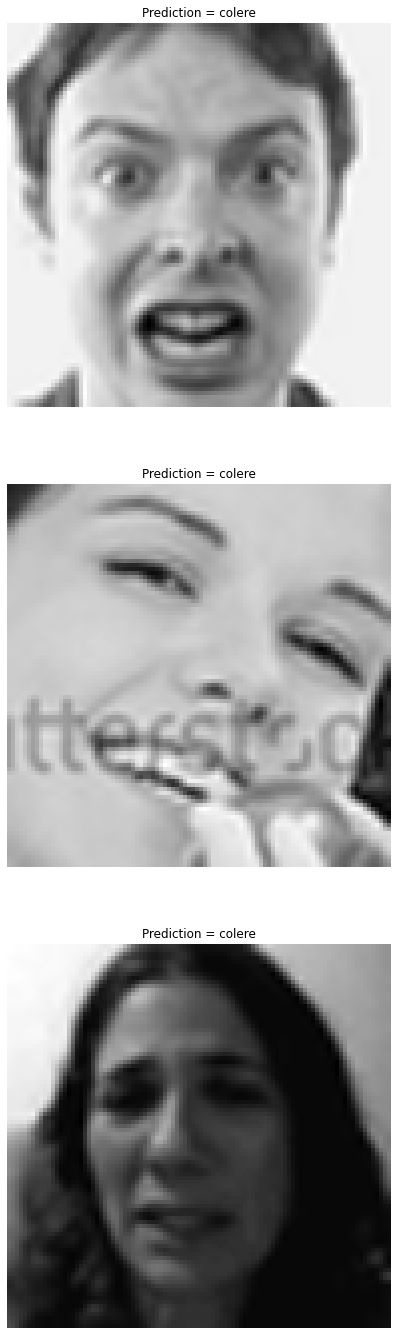

In [ ]:
#Plotting the test images and their predicted keypoints and emotions

fig, axes = plt.subplots(3, 1, figsize = (24, 24))
axes = axes.ravel()

for i in range(3):

    axes[i].imshow(X_test[i].squeeze(),cmap='gray')
    axes[i].set_title('Prediction = {}'.format(labels[preds[i].argmax()]))
    axes[i].axis('off')
    
    #for j in range(1,31,2):
    #        axes[i].plot(df_predict.loc[i][j-1], df_predict.loc[i][j], 'rx')
            

- We'll use the command line utility saved_model_cli to look at the MetaGraphDefs (the models) and SignatureDefs (the methods you can call) in our SavedModel. See this discussion of the SavedModel CLI in the TensorFlow Guide.

In [ ]:
!saved_model_cli show --dir {'/model/1'} --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['input'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 96, 96, 1)
        name: serving_default_input:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['dense_pred'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 5)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow/serving/predict
Traceback (most recent call last):
  File "/usr/local/bin/saved_model_cli", line 8, in <module>
    sys.exit(main())
  File "/usr/loc

# Partie NeuroEvolution (Meta-Learning), on va essayer d'apprendre la meilleur architecture et les meilleurs hyperparams

In [ ]:
NB_CLASSES = 5
INPUT_SHAPE = (96,96,1)

def create_and_compile_model(network):
    """ Créer & Compiler un modele residuel CNN fonctionnel
      sur la base de l'ADN du réseau à la volé => n'est conservé que le temps
      de l'entrainement.

    Args:
        network (dict): the parameters of the network

    Returns:
        a compiled network.

    """
    # Get our network parameters.
    """
    nb_layers = network['nb_layers']
    nb_filters = network['nb_filters']
    activation = network['activation']
    """
    optimizer = network['optimizer']

    # model = Sequential()
    x = None
    
    # Add each layer.
    for i in range(len(network)):

        # Need input shape for first layer.
        if i == 0:

            input = Input(shape = INPUT_SHAPE, name = 'input')

            # stage 0
            x = ZeroPadding2D(padding = 3)(input) # 3 en largeur (a gauche +droite), 3 en longueur (haut + bas)
            x = Conv2D(filters=64, kernel_size=(7,7), strides=(1,1), name = 'conv' + str(i))(x)
            x = BatchNormalization(axis = 3, name = 'bn_conv' + str(i))(x)
            x = Activation('relu')(x)
            x = ZeroPadding2D(padding = 1)(x) # 1 en largeur, 1 en longueur
            x = MaxPool2D(pool_size=(3, 3), strides=1, padding="valid")(x)
            
            #model.add(Dense(nb_neurons, activation=activation, input_shape=input_shape))

        else:
            x = res_block(x, network['cell_' + str(i)][0], i) # Pou cette version j'envois juste les filtres

        # model.add(Dropout(0.2))  # hard-coded dropout

    # Output layer.
    x = Flatten()(x)

    x = Dense(NB_CLASSES, activation='softmax', name = 'pred_dense')(x)

    model = Model(input, x, name = 'ResNet18')

    model.compile(loss='categorical_crossentropy', optimizer=optimizer,
                  metrics=['accuracy'])

    # model.summary()

    return model

def train_and_score(network):
    """Train the model, return test loss.

    Args:
        network (dict): the parameters of the network
        dataset (str): Dataset to use for training/evaluating

  
    if dataset == 'cifar10':
        nb_classes, batch_size, input_shape, x_train, \
            x_test, y_train, y_test = get_cifar10()
    elif dataset == 'mnist':
        nb_classes, batch_size, input_shape, x_train, \
            x_test, y_train, y_test = get_mnist()
    """

    model = create_and_compile_model(network)

    earlystopping = EarlyStopping(monitor='val_loss', min_delta = 10.0, patience = 5)

    #print(X_train, y_train, X_val, y_val)

    model.fit(datagen.flow(X_train, y_train, batch_size = 64), 
                          steps_per_epoch= len(X_train) // 64, 
                          epochs = 1000, # using early stopping, so no real limit
                          validation_data = (X_val, y_val),
                          validation_steps = X_val.shape[0] // 64, # step per epoch pour la partie validation | 64 = batch size
                          callbacks = [earlystopping],
                          verbose = 0
              )
    
    """
    model.fit(X_train, y_train,
              batch_size=batch_size,
              epochs=10000,  # using early stopping, so no real limit
              verbose=0,
              validation_data=(x_test, y_test),
              callbacks=[early_stopper])
    """

    # Evaluer les perfs du modèle - retourne la précison de la classification => [peut-être vaudra t'-il mieux se baser sur les autres KPI voir haut]
    score = model.evaluate(X_test, y_test, verbose=0)

    return score[1]  # 1 is accuracy. 0 is loss.

In [ ]:
"""Class that represents the network to be evolved."""
import random
import logging
import time

class Network():
    """Represent a network and let us operate on it.

    Currently only works for an MLP.

    Architecture = { 'cellule 1' : ( [filter_1, filter_2, filter_3], [stride_1, ....], [act_1, ....] ), 
                     'cellule 2' : ( [], [], [] ), 
                     ...
                     'optimizer :  }
    """

    def __init__(self, nn_param_choices=None):
        """Initialize our network.

        Args:
            Meta-data:
            nn_param_choices (dict): Parameters for the network, includes:
                nb_neurons/filters (list): [64, 128, 256]
                nb_layers/steps (list): [1, 2, 3, 4]
                kernel_size (list) : [3, 5, 7]
                stride (list) : [1, 2]
                activation (list): ['relu', 'elu']
                optimizer (list): ['rmsprop', 'adam']
        """
        self.accuracy = 0.
        self.loss = 1000
        self.nn_param_choices = nn_param_choices
        self.network = {}  # (dico): represents MLP network parameters architecture 

    def create_random(self):
        
        """ Créer un Reseau random en sélectionnat aléatoiremnt des caractéristiques dans l'ADN => Créer l'AND du Réseau """
        
        # Choose random layers
        nb_layers = random.choice(self.nn_param_choices['nb_layers'])

        for cell in range(0, nb_layers): # Chaque cellule represente un sous réseau resnet

          # Define cell name in dico"
          cell_name = 'cell_' + str(cell + 1)

          # Créer l'entrée dans le dico
          self.network[cell_name] = []

          for key in self.nn_param_choices.keys():

            if key is not 'nb_layers' and key is not 'optimizer':

              # Echantilloner à chaque fois 3 éléments dans l'ensemble des possibles
              self.network[cell_name].append( random.sample( self.nn_param_choices[key], k = 3 ) )

            elif key is 'optimizer':

              self.network['optimizer'] = random.choice( self.nn_param_choices[key] )

          # self.network[key] = random.choice(self.nn_param_choices[key])

    def create_set(self, network):
        """Set network properties.

        Args:
            network (dict): The network parameters

        """
        self.network = network

    def train(self):
        """Train the network and record the accuracy.

        Args:
            dataset (str): Name of dataset to use.

        """

        # Récupérer la classification précision du modèle sur test après entrainement
        if self.accuracy == 0.:
            self.accuracy = train_and_score(self.network)

    def print_network(self):
        """Print out a network."""
        logging.info(self.network)
        logging.info("Network accuracy: %.2f%%" % (self.accuracy * 100))
#

In [ ]:
from functools import reduce
from operator import add
import random

# permet de resituer chaque élement dans les cellules
str_To_idx = {
        'nb_filters': 0,
        'nb_layers': 0,
        'kernel_size' : 1,
        'stride' : 2,
        'activation': 3,
        'optimizer': 4,
    }

class Optimizer():
    """Class that implements genetic algorithm for MLP optimization."""

    def __init__(self, nn_param_choices, retain=0.5,
                 random_select=0.1, mutate_chance=0.2):
        """Create an optimizer.

        Args:
            nn_param_choices (dict): Possible network paremters
            retain (float): Percentage of population to retain after
                each generation
            random_select (float): Probability of a rejected network
                remaining in the population
            mutate_chance (float): Probability a network will be
                randomly mutated

        """
        self.mutate_chance = mutate_chance
        self.random_select = random_select
        self.retain = retain
        self.nn_param_choices = nn_param_choices

    def create_population(self, count):
        """Create a population of random networks.

        Args:
            count (int): Number of networks to generate, aka the
                size of the population

        Returns:
            (list): Population of network objects

        """
        pop = []
        for _ in range(0, count):
            # Create a random network.
            network = Network(self.nn_param_choices)
            network.create_random()

            print(network.network.keys(), network.network.values())
            time.sleep(2)

            # Add the network to our population.
            pop.append(network)

        return pop

    @staticmethod
    def fitness(network):
        """Return the accuracy, which is our fitness function."""
        return network.accuracy

    def grade(self, pop):
        """Find average fitness for a population.

        Args:
            pop (list): The population of networks

        Returns:
            (float): The average accuracy of the population

        """
        summed = reduce(add, (self.fitness(network) for network in pop))
        return summed / float((len(pop)))

    def breed(self, mother, father):
        """Make two children as parts of their parents.

        Args:
            mother (dict): Network parameters
            father (dict): Network parameters

        Returns:
            (list): Two network objects

        """
        children = []
        for _ in range(2):

            # ADN fils
            child = {}

            # Loop through the parameters and pick params for the kid from the mother or father.
            """
            for param in self.nn_param_choices:
                child[param] = random.choice(
                    [mother.network[param], father.network[param]]
                )
            """
            for i in range(max(len(father), len(mother))):

              cell = 'cell_' + str(i+1)

              if cell in father.keys() and cell in mother.keys():
                # Choisir au hasard 50/50
                child[cell] = random.choice(pere[cell], mother[cell])
              
              elif cell in father.keys() and cell not in mother.keys():
                # Prendre ou ne pas prendre
                child[cell] = (lambda x : x if random.random() > 0.5 else None)(pere[cell])

              elif cell not in father.keys() and cell in mother.keys():
                # Prendre ou ne pas prendre
                child[cell] = (lambda x : x if random.random() <= 0.5 else None)(mere[cell])

            # Finir en ajoutant l'"opt"
            chile['optimizer'] = random.choice(pere['optimizer'], mere['optimizer'])

            # Now create a network object.
            network = Network(self.nn_param_choices) # Moule général
            network.create_set(child) # Ajouter le particulier

            # Randomly mutate some of the children.
            if self.mutate_chance > random.random():
                network = self.mutate(network)

            children.append(network)

        return children

    def mutate(self, network):
        """Randomly mutate one part of the network.

        Args:
            network (dict): The network parameters to mutate

        Returns:
            (Network): A randomly mutated network object

        """
        # Choose a random key.
        mutation = random.choice(list(self.nn_param_choices.keys()))

        # Get the position in Cell
        idx = str_To_idx[mutation]

        # Choose the cell to mutate
        cell = random.choice(network.network.keys())

        # Mutate the params value.
        #network.network[mutation] = random.choice(self.nn_param_choices[mutation])
        network.network[cell][idx][random.randint(0, 2)] = random.choice(self.nn_param_choices[mutation])
        
        return network

    def evolve(self, pop):
        """ Faire evoluer une population de networks.

        Args:
            pop (list): A list of network parameters

        Returns:
            (list): The evolved population of networks

        """
        # Get scores for each network.
        graded = [(self.fitness(network), network) for network in pop]

        # Sort Nets x[1] liste on the scores parts from better to worst.
        graded = [x[1] for x in sorted(graded, key=lambda x: x[0], reverse=True)]

        # Get the number we want to keep for the next gen / Un peu moins excluant que de filtrer pâr valeur seuil de précision (seuil qui augmenterai par itération)
        retain_length = int(len(graded) * self.retain)

        # The parents are every network we want to keep.
        parents = graded[:retain_length]

        # For those we aren't keeping, randomly keep some anyway. peut-être a la génération suivante - Chance de devenir meilleurs
        for individual in graded[retain_length:]:
            if self.random_select > random.random():
                parents.append(individual)

        # Now find out how many spots we have left to fill.
        parents_length = len(parents)
        desired_length = len(pop) - parents_length # Les enfant remplace une partie de la population non-retenue
        children = []

        # Add children, which are bred from two remaining networks.
        while len(children) < desired_length:

            # Get a random mom and dad.
            male = random.randint(0, parents_length-1)
            female = random.randint(0, parents_length-1)

            # Assuming they aren't the same network...
            if male != female:
                male = parents[male]
                female = parents[female]

                # Breed them.
                babies = self.breed(male, female)

                # Add the children one at a time.
                for baby in babies:
                    # Don't grow larger than desired length.
                    if len(children) < desired_length:
                        children.append(baby)

        parents.extend(children)

        return parents


In [ ]:
from tqdm import tqdm

def train_networks(networks):
    """Train each network.

    Args:
        networks (list): Current population of networks
        dataset (str): Dataset to use for training/evaluating
    """
    pbar = tqdm(total=len(networks)) # Créer une barre de progression graphique (https://www.pythonpool.com/python-tqdm/)
    for network in networks:
        network.train()
        pbar.update(1)
    pbar.close()

def get_average_accuracy(networks):
    """Get the average accuracy for a group of networks.

    Args:
        networks (list): List of networks

    Returns:
        float: The average accuracy of a population of networks.

    """
    total_accuracy = 0
    for network in networks:
        total_accuracy += network.accuracy

    return total_accuracy / len(networks)

def generate(generations, population, nn_param_choices):
    """Generate a network with the genetic algorithm.

    Args:
        generations (int): Number of times to evole the population
        population (int): Number of networks in each generation
        nn_param_choices (dict): Parameter choices for networks
        dataset (str): Dataset to use for training/evaluating

    """
    optimizer = Optimizer(nn_param_choices)
    networks = optimizer.create_population(population)

    # Evolve the generation.
    for i in range(generations):
        logging.info("***Doing generation %d of %d***" %
                     (i + 1, generations))

        # Train and get accuracy for networks sur l'environnement.
        train_networks(networks)

        # Get the average accuracy for this generation.
        average_accuracy = get_average_accuracy(networks)

        # Print out the average accuracy each generation.
        logging.info("Generation average: %.2f%%" % (average_accuracy * 100))
        logging.info('-'*80)

        # Evolve, except on the last iteration.
        if i != generations - 1:
            # Do the evolution :
            networks = optimizer.evolve(networks)

    # Sort our final population.
    networks = sorted(networks, key=lambda x: x.accuracy, reverse=True)

    # Print out the top 5 networks.
    print_networks(networks[:5])

In [ ]:
def main():

    """Evolve a network."""
    generations = 5   # Number of times to evole the population.
    population = 5    # Number of networks in each generation.
    dataset = (X_train, y_train)

    # Liste des hyperparamêtres influençables
    """
      - Nb de filtre
      - Le kernel size (taille du filtre)
      - Le stride
      - Nombre de cellules ou steps (=un sous réseau, composé de block ID ou Conv)
      - Optimizer
      - Activation
    """
    nn_param_choices = {
        'nb_filters': [64, 128, 256, 512, 768, 1024],
        'nb_layers': [1, 2, 3, 4, 5],
        'kernel_size' : [3, 5, 7],
        'stride' : [1, 2, 3],
        'activation': ['relu', 'elu', 'tanh', 'sigmoid'],
        'optimizer': ['rmsprop', 'adam', 'sgd', 'adagrad',
                      'adadelta', 'adamax', 'nadam'],
    }

    # Générer un algo sur cet ADN
    generate(generations, population, nn_param_choices)

main()

dict_keys(['cell_1', 'optimizer']) dict_values([[[64, 1024, 512], [5, 3, 7], [3, 1, 2], ['relu', 'elu', 'tanh']], 'sgd'])
dict_keys(['cell_1', 'optimizer', 'cell_2', 'cell_3', 'cell_4']) dict_values([[[512, 256, 768], [5, 3, 7], [2, 1, 3], ['elu', 'sigmoid', 'tanh']], 'adagrad', [[128, 768, 64], [5, 7, 3], [1, 3, 2], ['relu', 'elu', 'sigmoid']], [[64, 256, 1024], [7, 3, 5], [1, 3, 2], ['sigmoid', 'elu', 'relu']], [[256, 128, 1024], [7, 3, 5], [2, 3, 1], ['sigmoid', 'relu', 'elu']]])
dict_keys(['cell_1', 'optimizer']) dict_values([[[768, 256, 1024], [5, 7, 3], [3, 1, 2], ['tanh', 'relu', 'elu']], 'adam'])
dict_keys(['cell_1', 'optimizer', 'cell_2']) dict_values([[[64, 768, 128], [5, 3, 7], [2, 3, 1], ['relu', 'sigmoid', 'elu']], 'nadam', [[128, 768, 1024], [7, 3, 5], [2, 1, 3], ['sigmoid', 'elu', 'tanh']]])
dict_keys(['cell_1', 'optimizer', 'cell_2', 'cell_3', 'cell_4', 'cell_5']) dict_values([[[512, 64, 256], [3, 5, 7], [3, 1, 2], ['elu', 'sigmoid', 'tanh']], 'adagrad', [[128, 512, 102






  0%|          | 0/5 [00:00<?, ?it/s]

Model: "ResNet18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 96, 96, 1)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_10 (ZeroPadding2 (None, 102, 102, 1)  0           input[0][0]                      
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 96, 96, 64)   3200        zero_padding2d_10[0][0]          
__________________________________________________________________________________________________
bn_conv0 (BatchNormalization)   (None, 96, 96, 64)   256         conv0[0][0]                      
___________________________________________________________________________________________






 20%|██        | 1/5 [34:02<2:16:09, 2042.29s/it]

Model: "ResNet18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 96, 96, 1)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_12 (ZeroPadding2 (None, 102, 102, 1)  0           input[0][0]                      
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 96, 96, 64)   3200        zero_padding2d_12[0][0]          
__________________________________________________________________________________________________
bn_conv0 (BatchNormalization)   (None, 96, 96, 64)   256         conv0[0][0]                      
___________________________________________________________________________________________






 40%|████      | 2/5 [1:20:01<1:52:52, 2257.47s/it]

Model: "ResNet18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 96, 96, 1)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_14 (ZeroPadding2 (None, 102, 102, 1)  0           input[0][0]                      
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 96, 96, 64)   3200        zero_padding2d_14[0][0]          
__________________________________________________________________________________________________
bn_conv0 (BatchNormalization)   (None, 96, 96, 64)   256         conv0[0][0]                      
___________________________________________________________________________________________

ResourceExhaustedError: ignored

* # experience

In [ ]:
import random
import tqdm

nn_param_choices = {
        'nb_filters': [64, 128, 256, 512, 768, 1024],
        'nb_layers': [1, 2, 3, 4, 5],
        'kernel_size' : [3, 5, 7],
        'stride' : [1, 2],
        'activation': ['relu', 'elu', 'tanh', 'sigmoid'],
        'optimizer': ['rmsprop', 'adam', 'sgd', 'adagrad',
                      'adadelta', 'adamax', 'nadam'],
}

nn_param_choices2 = {
        'nb_filters': [64, 128, 256, 512, 768, 1024],
        'nb_layers': [1, 2, 3, 4, 5],
        'kernel_size' : [3, 5, 7],
        'stride' : [1, 2],
        'activation': ['relu', 'elu', 'tanh', 'sigmoid']
}

pere = {
    'cell_1' : [[1,2,3], [4,5,6], [7,8,9]],
    'opt' : 'elu'
}

mere = {
    'cell_1' : [[1,2,3], [4,5,6], [7,8,9]],
    'cell_2' : [[10,20,30], [40,50,60], [70,80,90]],
    'opt' : 'relu'
}

random.choice(nn_param_choices['nb_filters'])

liste =  [ nn_param_choices['nb_filters'][0] ] * nn_param_choices['nb_layers'][4]

In [ ]:
for k in zip(nn_param_choices.keys(), nn_param_choices2.keys()):
  print(k)

('nb_filters', 'nb_filters')
('nb_layers', 'nb_layers')
('kernel_size', 'kernel_size')
('stride', 'stride')
('activation', 'activation')


In [ ]:
for k in itertools.zip_longest(mere.keys(), pere.keys()):
  print(k)

('cell_1', 'cell_1')
('cell_2', 'opt')
('opt', None)


In [ ]:
if 'cell_2' not in pere.keys() and 'cell_2' in mere.keys():
  print("a")

a


In [ ]:
nn_param_choices['architecture'] = [[1,2,3], [4,5,6], [7,8,9]]
nn_param_choices2['architecture'] = [[1,2,3], [4,5,6], [7,8,9]]

In [ ]:
nn_param_choices['architecture'][0][random.randint(0,2)]

3

In [ ]:
nn_param_choices['architecture'][1:]

[[4, 5, 6], [7, 8, 9]]

In [ ]:
random.choice([1]), random.randint(0, 2)

(1, 2)

In [ ]:
liste = list([1,2,34])
liste.extend([5,6])
liste2 = [1,2]

In [ ]:
random.sample( nn_param_choices['stride'], k = 3 )

ValueError: ignored

In [ ]:
random.choices( nn_param_choices['kernel_size'], k = 3 )

[5, 3, 5]

In [ ]:
child = {}
child['opt'] = (lambda x : x if random.random() > 0.5 else None)(pere['opt'])

child['opt']

'elu'